In [2]:
import detectevent
from detectevent import DetectEvent
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

In [3]:
%matplotlib ipympl

In [ ]:
detector = detectevent.DetectEvent()

# Load data - adjust the file path and column names to match your CSV
data = detector.load_data("usgs_gage_data.csv",
                            time_column="datetime",
                            value_column="gage_height",
                            date_format="%Y-%m-%d %H:%M:%S")

# Detect events using a simple threshold approach
events = detector.detect_events_threshold(threshold=10.0,  # adjust threshold based on your data
                                        min_duration=30,   # minimum 30 minutes
                                        rise_rate=0.5)     # 0.5 feet per hour rise rate

# Alternatively, detect events using moving average approach
# events = detector.detect_events_moving_average(window_size=48,  # 48 data points
#                                              std_factor=2.5,   # 2.5 standard deviations
#                                              min_duration=30)  # minimum 30 minutes

# Visualize the results
detector.visualize_events(events, title="USGS Gage Height Events")

In [ ]:
data = pd.read_csv('usgs-data/01302020.csv')
time = data['datetime'].to_numpy()
height = data['00065'].to_numpy()
plt.clf()
# plt.plot(height[:-1], np.diff(height), color='purple', alpha= 0.5)
plt.plot(time, height)
plt.show()

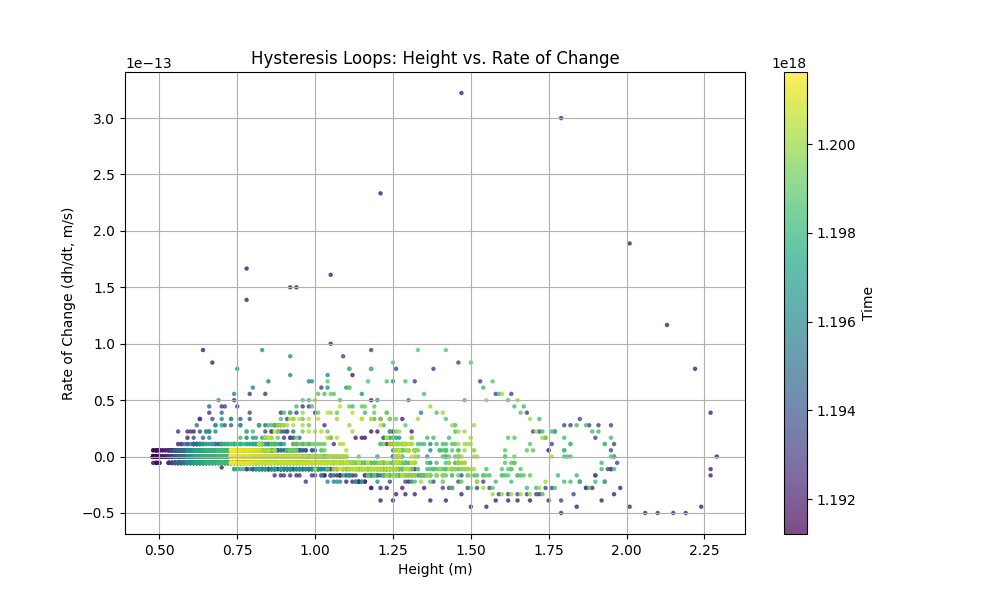

In [43]:
df = pd.read_csv('usgs-data/01302020_shorter2.csv')

df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S%z")

# method 1
df['time_num'] = df['datetime'].astype(np.int64)
df['dh_dt'] = np.gradient(df['00065'], df['time_num'])

# method 2
# df['dh_dt'] = df['00065'].diff() / df['datetime'].diff().dt.total_seconds()

plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df['00065'],
    df['dh_dt'],
    c=df['time_num'],  # Color by time
    cmap='viridis',
    s=5,
    alpha=0.7
)
plt.colorbar(sc, label='Time')
plt.xlabel('Height (m)')
plt.ylabel('Rate of Change (dh/dt, m/s)')
plt.title('Hysteresis Loops: Height vs. Rate of Change')
# Add arrows to indicate loop direction
plt.annotate(
    'Flood Rise', xy=(5.0, 0.02), xytext=(1.5, 1e-13),
    arrowprops=dict(arrowstyle="->", color='red')
)
plt.annotate(
    'Flood Recession', xy=(5.5, -0.01), xytext=(6.0, -0.02),
    arrowprops=dict(arrowstyle="->", color='blue')
)
plt.grid()

# flood_events = df[(df['dh_dt'] > 1e-7) & (df['00065'] > 0)]  # 0.05 ft/s and height >5ft


# Rolling 95th percentile of dh/dt (adaptive to seasonal changes)
# df['rise_threshold'] = df['dh_dt'].rolling(7).quantile(0.95)
# flood_events = df[df['dh_dt'] > df['rise_threshold']]

# Dynamic threshold (top 5% of positive rates)
# threshold = df['dh_dt'].quantile(0.90)
# floods = df[(df['dh_dt'] > threshold) & (df['00065'] > df['00065'].quantile(0.35))]

# Plot
# plt.figure(figsize=(12, 6))
# plt.plot(df['00065'], df['dh_dt'])
# plt.plot(df['datetime'], df['00065'], label='Height')
# plt.scatter(floods['datetime'], floods['00065'], color='red', label='Flood Events')
# plt.scatter(flood_events['datetime'], flood_events['00065'], color='red', label='Flood Events')
# plt.legend()

In [60]:
from scipy.integrate import simpson  # Updated import

rising = df[df['dh_dt'] > 0]    # Water level increasing
falling = df[df['dh_dt'] < 0]   # Water level decreasing

# Calculate loop area for each event
events = []
for h_threshold in np.linspace(df['00065'].quantile(0.1), df['00065'].quantile(0.9), 5):
    # Get rising and falling segments at this height range
    mask_rising = (rising['00065'] >= h_threshold - 0.5) & (rising['00065'] <= h_threshold + 0.5)
    mask_falling = (falling['00065'] >= h_threshold - 0.5) & (falling['00065'] <= h_threshold + 0.5)

    rising_segment = rising[mask_rising].sort_values('00065')
    falling_segment = falling[mask_falling].sort_values('00065')

    if len(rising_segment) > 2 and len(falling_segment) > 2:  # Need at least 3 points for simpson
        area = (simpson(rising_segment['dh_dt'], rising_segment['00065']) -
               simpson(falling_segment['dh_dt'], falling_segment['00065']))

        events.append({
            'start_time': rising_segment['datetime'].min(),
            'peak_time': rising_segment.loc[rising_segment['00065'].idxmax(), 'datetime'],
            'end_time': falling_segment['datetime'].max(),
            'max_height': rising_segment['00065'].max(),
            'loop_area': abs(area),  # Absolute value for magnitude
            'direction': 'clockwise' if area > 0 else 'counter-clockwise'
        })

events_df = pd.DataFrame(events)

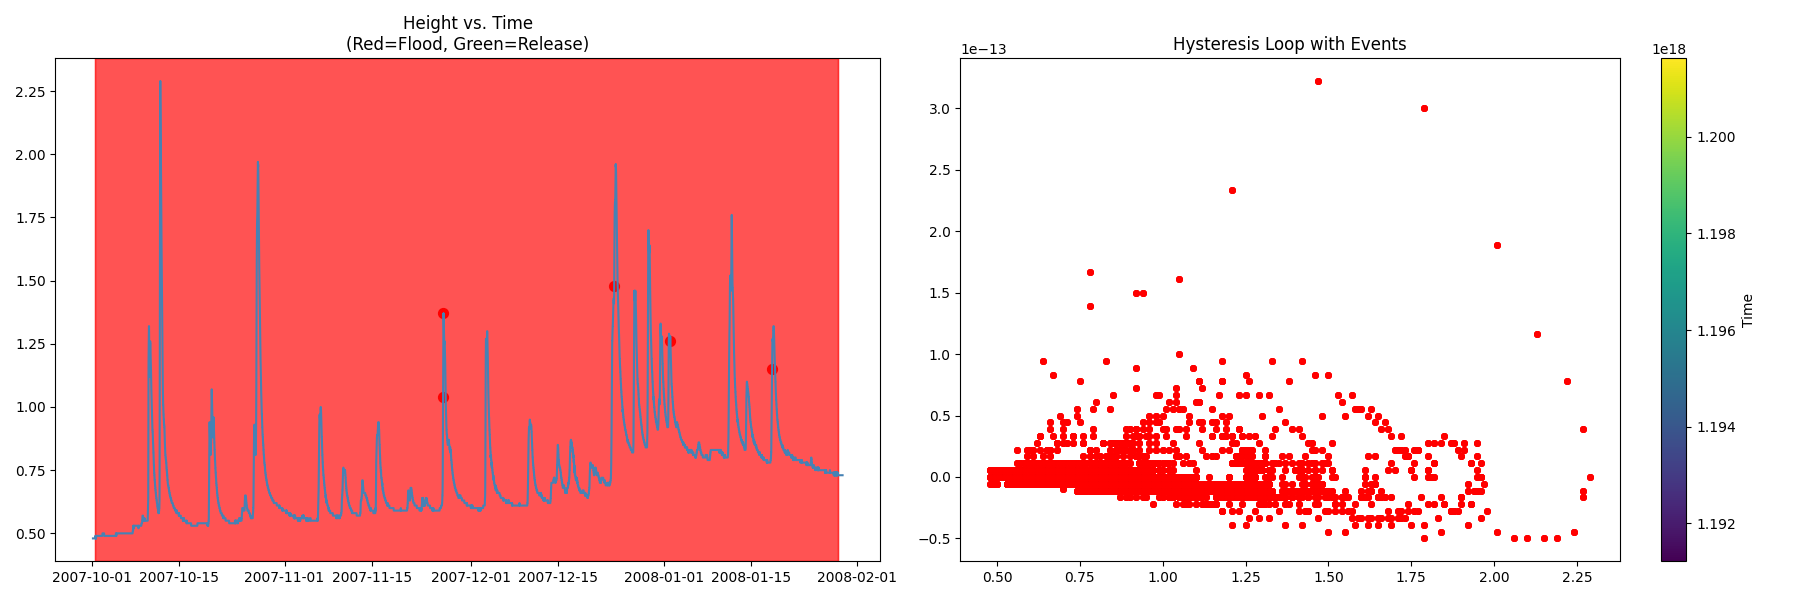

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), dpi=100)

# 1. Time series plot
ax1.plot(df['datetime'], df['00065'], 'steelblue', label='Height')
for _, event in events_df.iterrows():
    color = 'red' if event['direction'] == 'clockwise' else 'green'
    ax1.axvspan(event['start_time'], event['end_time'], color=color, alpha=0.2)
    ax1.scatter(event['peak_time'], event['max_height'], color=color, s=50)
ax1.set_title('Height vs. Time\n(Red=Flood, Green=Release)')

# 2. Hysteresis plot with event highlights
sc = ax2.scatter(df['00065'], df['dh_dt'], c=df['datetime'].astype(np.int64), cmap='viridis', s=5)
for _, event in events_df.iterrows():
    mask = (df['datetime'] >= event['start_time']) & (df['datetime'] <= event['end_time'])
    ax2.scatter(df.loc[mask, '00065'], df.loc[mask, 'dh_dt'],
                color='red' if event['direction'] == 'clockwise' else 'green', s=15)
ax2.set_title('Hysteresis Loop with Events')

plt.colorbar(sc, ax=ax2, label='Time')
plt.tight_layout()

In [54]:
rising = df[df['dh_dt'] > 0]    # Water level increasing
falling = df[df['dh_dt'] < 0]   # Water level decreasing

min_h, max_h = df['00065'].min(), df['00065'].max()
h_bins = np.linspace(min_h, max_h, 20)

for i in range(len(h_bins) - 1):
    h_low, h_high = h_bins[i], h_bins[i + 1]
    rising_segment = rising[(rising['00065'] >= h_low) & (rising['00065'] <= h_high)]
    falling_segment = falling[(falling['00065'] >= h_low) & (falling['00065'] <= h_high)]

    if len(rising_segment) > 10 and len(falling_segment) > 10:  # Minimum points
        print(f"Possible loop between {h_low:.2f}m and {h_high:.2f}m")

Possible loop between 0.48m and 0.58m
Possible loop between 0.58m and 0.67m
Possible loop between 0.67m and 0.77m
Possible loop between 0.77m and 0.86m
Possible loop between 0.86m and 0.96m
Possible loop between 0.96m and 1.05m
Possible loop between 1.05m and 1.15m
Possible loop between 1.15m and 1.24m
Possible loop between 1.24m and 1.34m
Possible loop between 1.34m and 1.43m
Possible loop between 1.43m and 1.53m
Possible loop between 1.62m and 1.72m
Possible loop between 1.72m and 1.81m


In [58]:
from scipy.integrate import simpson

# Example: Integrate dh/dt over height for a segment
loop_area = simpson(rising_segment['dh_dt'], rising_segment['00065']) #- \
            # simpson(falling_segment['dh_dt'], falling_segment['00065'])
print(f"Loop area: {loop_area:.4f} (m²/s)")

Loop area: 0.0000 (m²/s)


In [53]:
2112+8363+1078

11553

In [50]:
df.shape

(11553, 6)

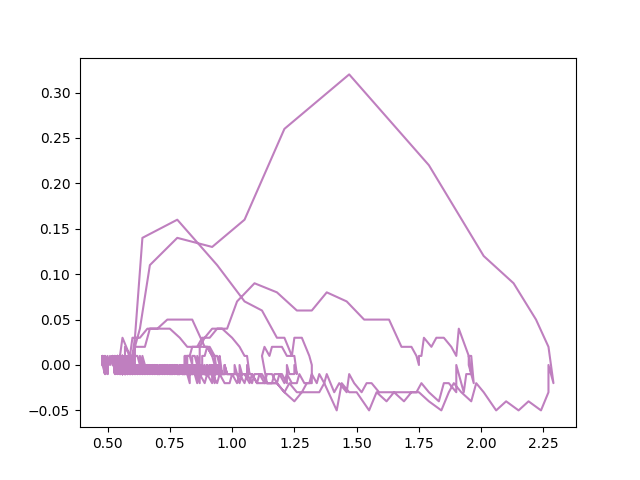

In [5]:
# data = pd.read_csv('usgs-data/01302020_shorter2.csv')
# time = data['datetime'].to_numpy()
# height = data['00065'].to_numpy()
# plt.clf()
# plt.plot(height[:-1], np.diff(height), color='purple', alpha= 0.5)
# plt.show()

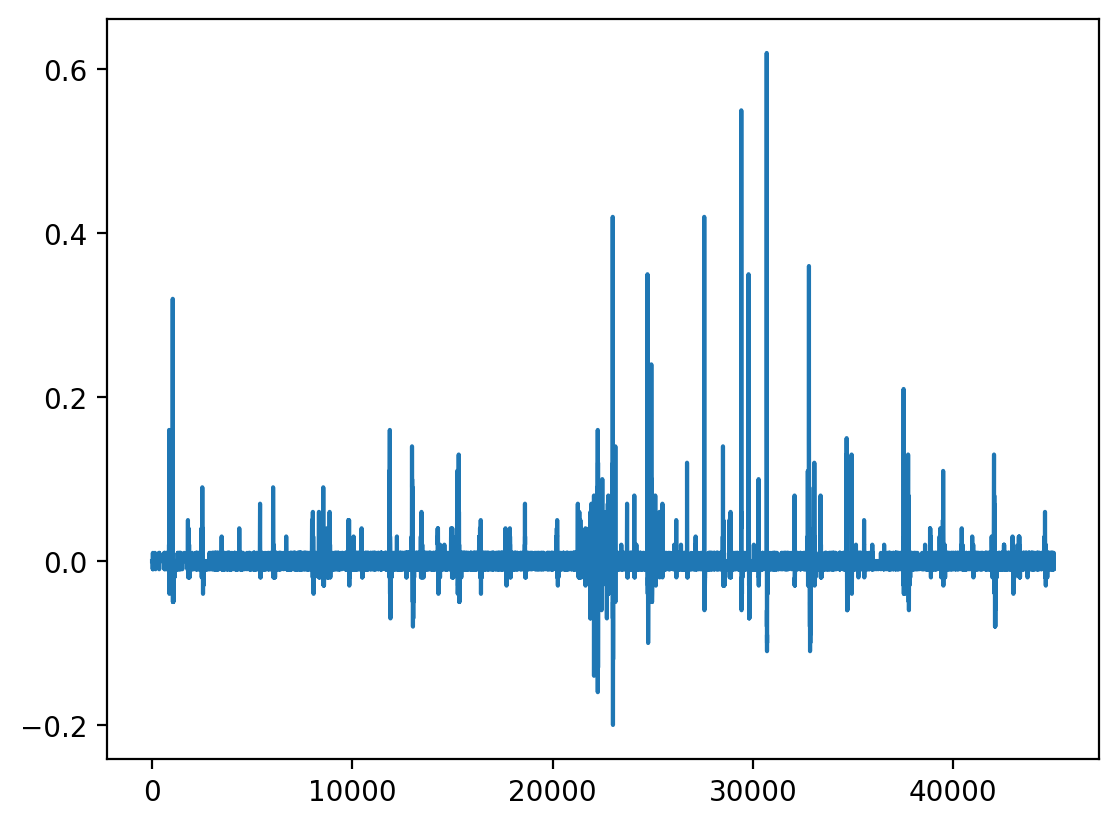

In [6]:
%matplotlib inline
plt.clf()
plt.plot(np.diff(height))
plt.show()

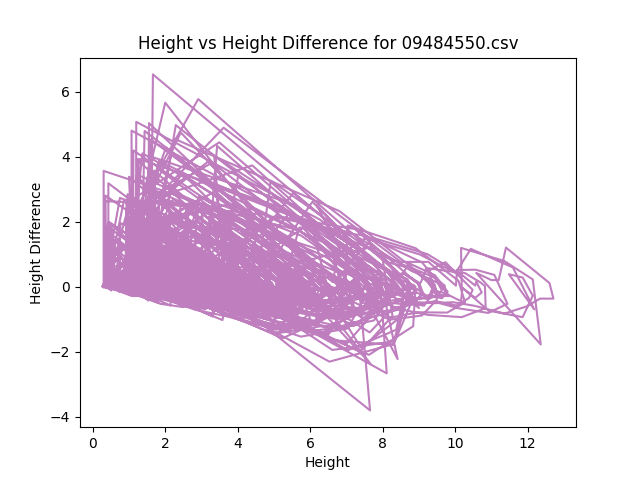

/var/folders/pq/w466krps4015y7cfwg_sl2_40000gn/T/ipykernel_6439/3378440164.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


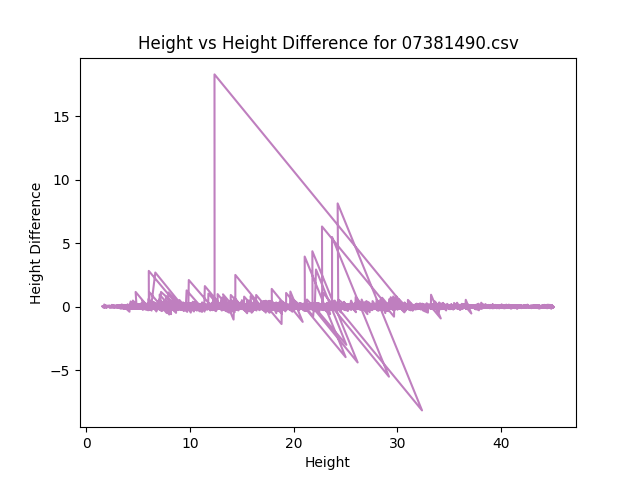

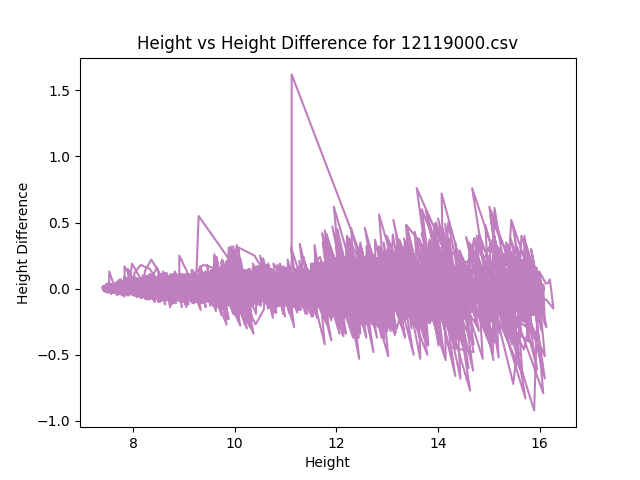

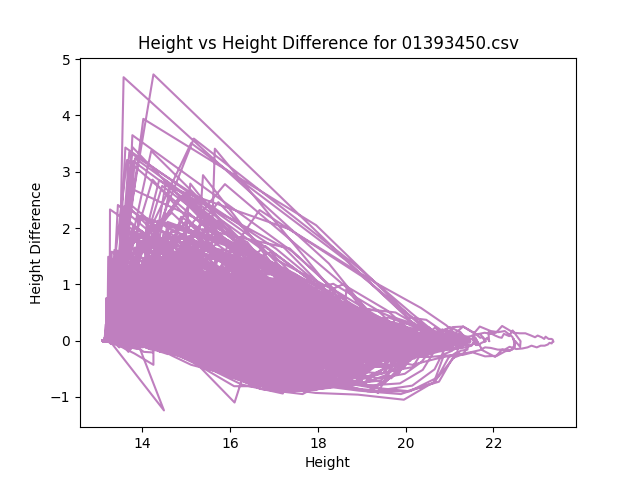

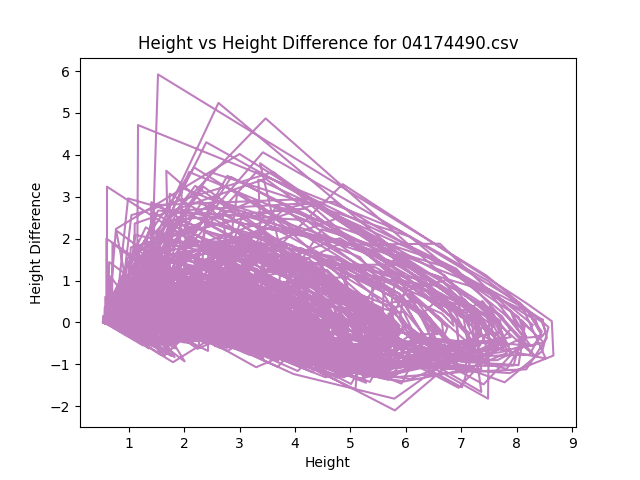

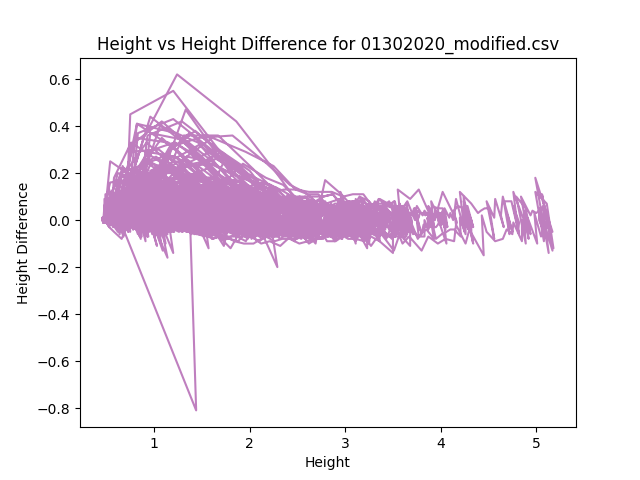

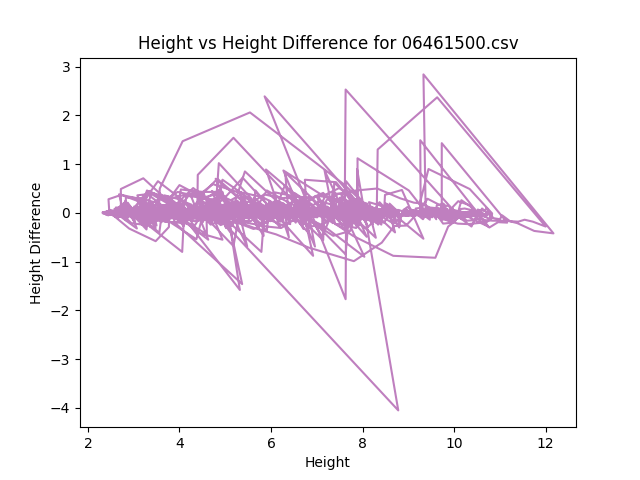

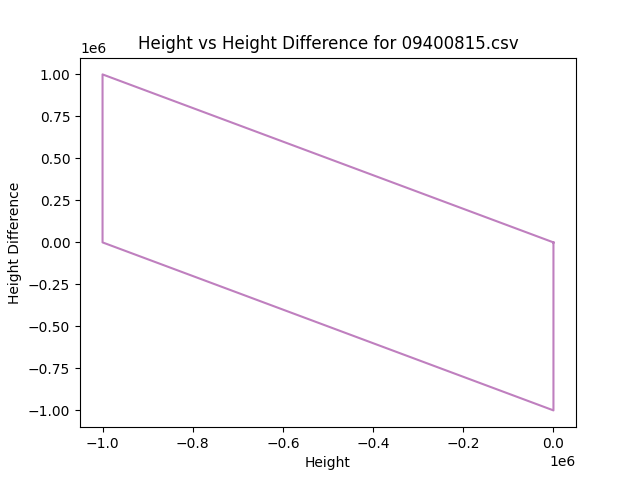

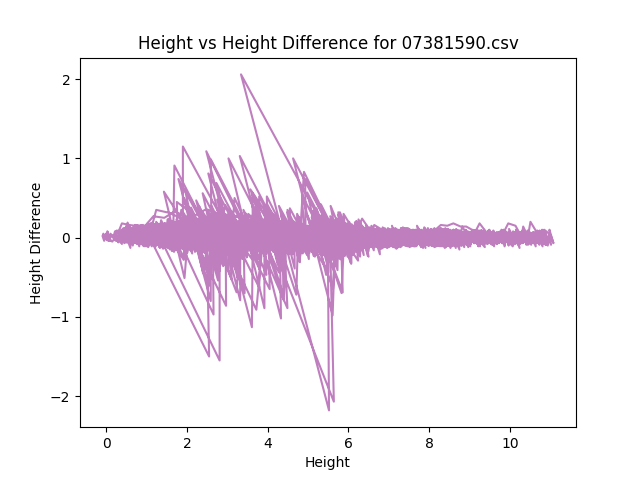

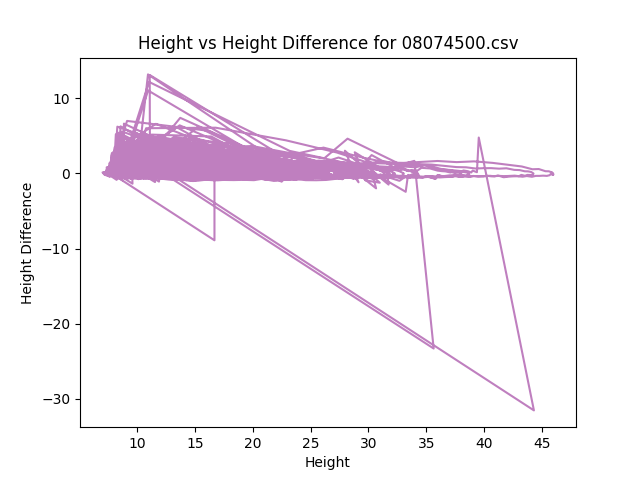

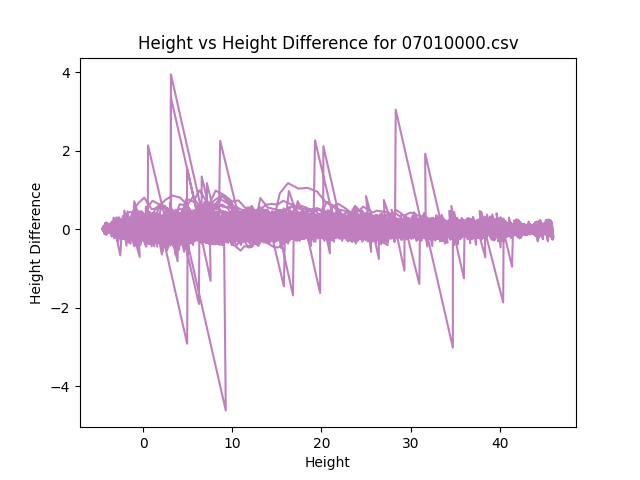

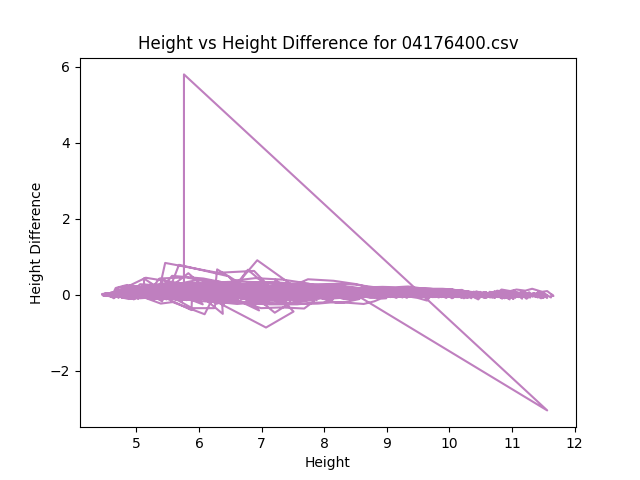

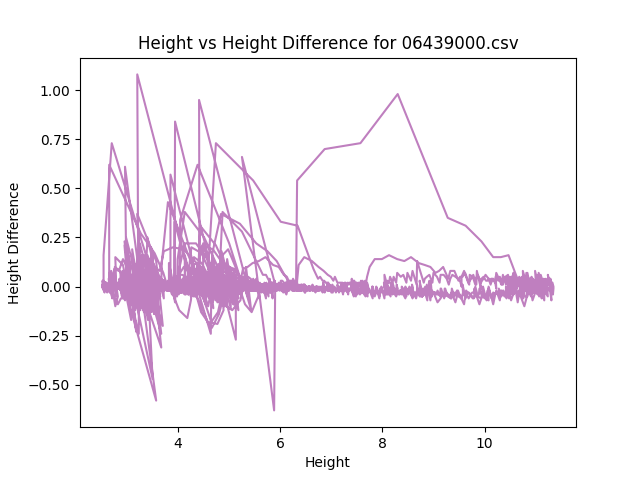

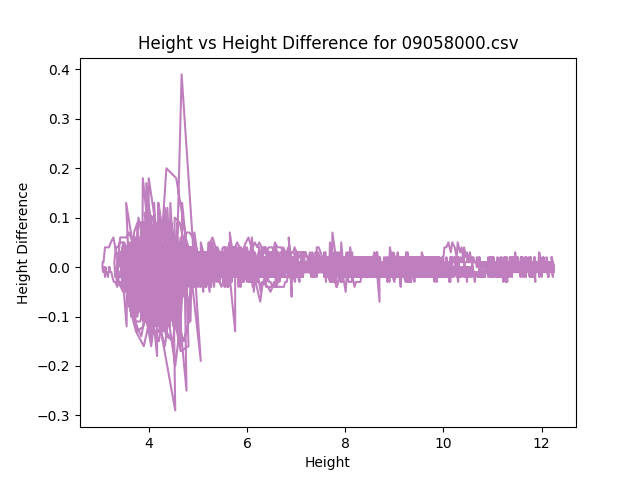

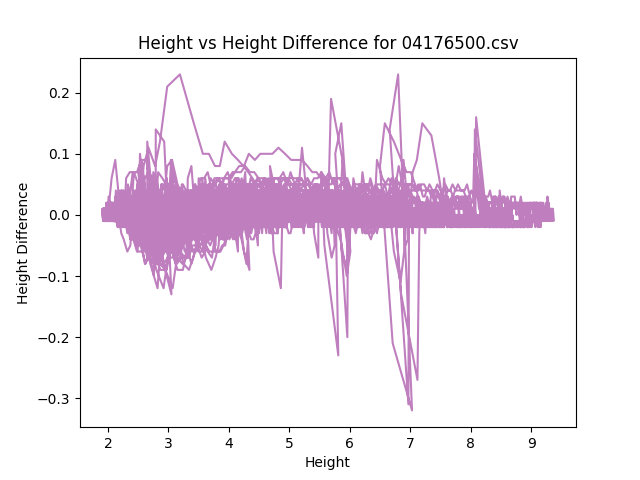

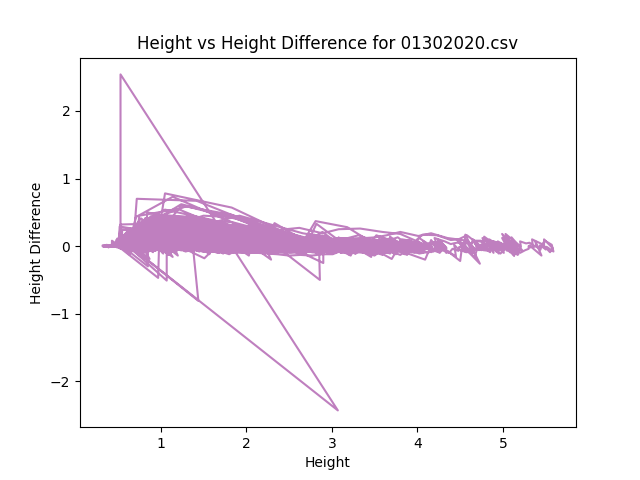

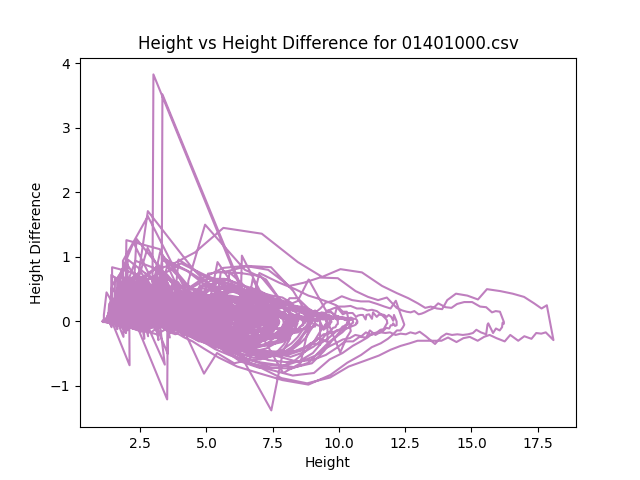

In [13]:
# Get list of CSV files in the usgs-data directory
csv_files = glob.glob('usgs-data/*.csv')

# Loop through each CSV file
for csv_file in csv_files:
    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Extract time and height data
    time = data['datetime'].to_numpy()
    height = data['00065'].to_numpy()

    # Create new figure for each file
    plt.figure()

    # Plot the data
    plt.plot(height[:-1], np.diff(height), color='purple', alpha=0.5)
    plt.title(f'Height vs Height Difference for {os.path.basename(csv_file)}')
    plt.xlabel('Height')
    plt.ylabel('Height Difference')
    plt.show()